In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import preprocessing
from sklearn import metrics

import random
from scipy import stats
import shap

pd.set_option('display.max_rows',20)
pd.set_option('display.max_columns',20)

/opt/anaconda3/envs/obesity_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* 국민건강영양조사 원시자료 2016 ~ 2018 (7기)

In [2]:
data_16 = pd.read_csv("Data/hn2016_all.csv",encoding='utf-8', low_memory=False)
data_17 = pd.read_csv("Data/hn2017_all.csv",encoding='utf-8', low_memory=False)
data_18 = pd.read_csv("Data/hn2018_all.csv",encoding='utf-8', low_memory=False)
# data_19 = pd.read_csv("Data/hn2019_all.csv",encoding='utf-8', low_memory=False)
print(data_16.shape, data_17.shape, data_18.shape)

(6382, 800) (6518, 858) (6489, 786)


In [3]:
data = pd.concat([data_16, data_17, data_18], axis=0).reset_index()
data.drop(['index'], axis=1, inplace=True)

In [4]:
# 중복 확인
pd.Series(data[['ID', 'ID_fam']].duplicated()).value_counts()

False    19389
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19389 entries, 0 to 19388
Columns: 922 entries, mod_d to HE_UNa_etc
dtypes: float64(1), int64(19), object(902)
memory usage: 136.4+ MB


결측치 확인

# 결측치

* 데이터 별로 특정 년도에만 해당하는 변수들이 있음 -> 해당 컬럼 제거

```
    # 6382 -> 16년도 자료에 없음
    # 6518 -> 17년 자료에 없음
    # 6489개 -> 18년도 자료에 없음
    # 13007개 -> 17, 18년도 자료에 없음
    # 12871 -> 16, 18년도 자료에 없음
    # 12900 -> 16, 17년도 자료에 없음
```

In [6]:
null_df = pd.DataFrame(data.isnull().sum())
tmp = pd.DataFrame(data.isnull().sum() > 0, columns = ['null'])
null_idx = tmp[tmp['null'] == True].index
print(len(null_idx)) # 191개
null_df.loc[null_idx, :].value_counts()

191


12871    82
13007    28
6489     26
12900    21
6382     19
6518     15
dtype: int64

In [7]:
null_df.loc[null_idx, :].head(10)

,0
wt_hm,6489
wt_pfhm,6489
wt_hmnt,6489
wt_pfhmnt,6489
id_f,6489
id_m,6489
BH1_1,13007
BH1_2,13007
BH1_3,13007
BH1_8,13007


In [8]:
# 위의 결측치 컬럼 제거
data.drop(null_idx, axis=1, inplace=True)
print(data.shape) # 731 columns
data.drop(['mod_d',	'ID','ID_fam','year','region','town_t','apt_t','psu','age_month'], axis=1, inplace=True)
print(data.shape)

(19389, 731)
(19389, 722)


In [9]:
# BMI를 기준으로 라벨링 할 것이기 때문에 BMI에 결측치가 있다면 제거
# ▶ 변화 없음. 데이터가 다 있는것.
data.dropna(subset=['HE_BMI'], inplace=True)
data.shape

(19389, 722)

In [10]:
# nan이 아닌 빈칸들이 보임
data.head()

,sex,age,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,...,HEI_TVEG,HEI_VEG,HEI_PROTF,HEI_DAIRY,HEI_SFA,HEI_NA,HEI_SWEET,HEI_CHO,HEI_FAT,HEI_EN
0,1,61,3,3,4,4,4,7,3981.17872,7446.336475442,...,1.27977106985893,1.45191942606,10,0,7.1370828152065,9.02674466056115,10,5,5,5
1,2,57,3,3,4,4,4,6,3981.17872,4911.91211605026,...,3.39100650212314,1.12561040339703,1.0422991861288,0,0,7.19125343962297,10,4.55662031174439,5,0
2,2,41,3,3,3,4,4,1,3981.17872,4522.36986021191,...,1.89473635696982,.830951535636717,5.45569676719167,.388478494538393,8.64838740657575,8.62538297147442,10,5,5,4.14915416071761
3,1,39,3,3,4,4,4,3,3981.17872,7890.76969340113,...,,,,,,,,,,
4,2,38,3,3,4,4,4,7,3981.17872,3314.98358651851,...,,,,,,,,,,


# ' '등으로 채워진 빈칸을 NaN으로 바꿔줌
```
data.replace(' ', np.nan, inplace=True) 등으로 처리할 경우, ' ', '  ' 등등을 다 따로 처리해줘야함
```

In [11]:
for col in data.columns:
    data[col] = pd.to_numeric(data[col], errors='coerce').astype(float).round(2)

In [12]:
null_df = pd.DataFrame(data.isnull().sum())
tmp = pd.DataFrame(data.isnull().sum() > 0, columns=['null'])
null_idx = tmp[tmp['null'] == True].index
print(len(null_idx)) # 706개
null_df.loc[null_idx, :].value_counts()
# 836개, 903개 등등 겹치는건 row를 제거하는게 효과적일것임
# 살릴 수 있는 데이터는 살리면 좋으니까, 100개 이하인 데이터에 대해서 impute 진행

706


836      366
19389     44
2535      36
903       22
2520      16
        ... 
2528       1
2533       1
1061       1
1026       1
2110       1
Length: 91, dtype: int64

In [13]:
# 만개 가까이 되는것들은 columns을 drop
# 갯수가 작은것은 row를 drop

remove_col = null_df[null_df > 2000].dropna().index
data.drop(remove_col, axis=1, inplace=True)

In [14]:
remove_row = null_df[(null_df < 100) & (null_df >0)].dropna().index

In [15]:
# 결측치 100개 이하는 random sampling으로 impute
def random_value_imputation(feature):
    random_sample = data[feature].dropna().sample(data[feature].isna().sum())
    random_sample.index = data[data[feature].isnull()].index
    data.loc[data[feature].isnull(), feature] = random_sample

for col in remove_row:
    random_value_imputation(col)
    
print(data.shape)
# 결측치 100개 impute 한 결과
# 14693 rows -> 14727 rows 

(19389, 503)


In [16]:
data.dropna(how='any', inplace=True)

In [17]:
data

,sex,age,incm,ho_incm,incm5,ho_incm5,edu,occp,wt_hs,wt_itvex,...,T_NQ_LS_T,T_NQ_FIR,T_NQ_FIR_P,GS_use,GS_mea_r_1,GS_mea_r_2,GS_mea_r_3,GS_mea_l_1,GS_mea_l_2,GS_mea_l_3
0,1.0,61.0,3.0,3.0,4.0,4.0,4.0,7.0,3981.18,7446.34,...,888.0,1.0,2.0,1.0,35.5,38.6,38.4,33.6,35.1,35.4
2,2.0,41.0,3.0,3.0,3.0,4.0,4.0,1.0,3981.18,4522.37,...,888.0,2.0,8.0,1.0,27.3,25.7,26.9,23.9,24.4,22.4
3,1.0,39.0,3.0,3.0,4.0,4.0,4.0,3.0,3981.18,7890.77,...,888.0,8.0,8.0,1.0,39.7,43.2,37.7,38.8,40.7,32.0
4,2.0,38.0,3.0,3.0,4.0,4.0,4.0,7.0,3981.18,3314.98,...,888.0,8.0,8.0,1.0,22.4,20.4,19.0,23.3,22.3,25.0
5,2.0,44.0,4.0,4.0,5.0,5.0,4.0,1.0,3981.18,9044.74,...,888.0,2.0,8.0,1.0,21.1,23.4,24.7,21.4,23.0,23.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19383,2.0,70.0,2.0,1.0,2.0,1.0,1.0,7.0,438.93,307.49,...,888.0,2.0,8.0,3.0,19.0,17.6,16.1,17.8,17.0,16.7
19384,2.0,78.0,2.0,1.0,3.0,1.0,1.0,7.0,438.93,301.80,...,888.0,2.0,8.0,1.0,21.0,19.7,20.9,18.1,16.9,15.8
19385,1.0,69.0,2.0,2.0,3.0,3.0,2.0,4.0,438.93,350.02,...,888.0,1.0,2.0,1.0,33.2,33.4,34.3,36.0,34.9,35.3
19386,2.0,62.0,3.0,2.0,3.0,3.0,1.0,3.0,438.93,413.83,...,888.0,2.0,8.0,1.0,25.1,20.9,23.5,22.4,21.9,21.0


```
# 초반에 제거하면 너무 많은 데이터가 제거되는 문제가 생김
# 비해당과 상관관계가 있을까?
# 무응답은 결측치로 처리
# 비해당은 그냥 둘까?
# 8, 9가 선택지인 경우가 많음(FF_BARLEY, FF_BEER 등)
# 8, 9라고 막 지우면 안됨
# 데이터를 살펴보니 갯수가 11개보다 작으면 설문조사로 판단할 수 있을 것 같음
```

|value|discription|
|:---|:---|
| 888 | 비해당 |
| 999 | 모름 / 무응답 |
| 88 | 비해당 |
| 99 | 무응답 |
| 8 | 비해당 |
| 9 | 모름 / 무응답 |

In [18]:
# 88, 99, 888, 999는 np.nan으로 변환 후 결측치 개수 확인
# 88, 99 등으로 group_by 한다음에 확인할 수 있나? -> 변수가 너무 많아서 힘들것같음
data.replace(88, np.nan, inplace=True)
data.replace(99, np.nan, inplace=True)
data.replace(888, np.nan, inplace=True)
data.replace(999, np.nan, inplace=True)

tmp = pd.DataFrame(data.isnull().sum(), index = data.isnull().sum().index)
remove_col_idx = tmp[tmp > 500].dropna().index
# 결측치가 500개보다 작으면 row 제거(갯수 보면서 500개로 정함)

# column drop
data.drop(remove_col_idx, axis=1, inplace=True)
# row drop
data.dropna(how='any', inplace=True) #14727 -> 12337

In [19]:
# 이상치가 있어보이지는 않음.
data['HE_BMI'].describe()

count    12337.000000
mean        23.860952
std          3.452373
min         13.330000
25%         21.450000
50%         23.610000
75%         25.870000
max         43.560000
Name: HE_BMI, dtype: float64

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='HE_BMI', ylabel='Density'>

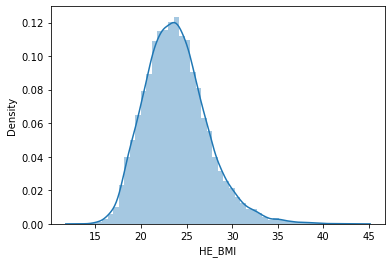

In [20]:
sns.distplot(data['HE_BMI'])

In [21]:
# ▶ 변수의 모든 조합, 상관계수 표현
plt.gcf().set_size_inches(15, 10)
sns.heatmap(data.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm', mask = np.triu(np.ones_like(data.corr(), dtype=np.bool)));

KeyboardInterrupt: 

<Figure size 1080x720 with 0 Axes>

# Issue
```
# 그래도 컬럼이 421개임 어떻게 축소할 것인지?
# 8, 9에 대한 처리 이후 MinMaxScaler, StandardScaer 활용해야함
# group by
```

In [55]:
# BMI 기준으로 Target 비닝
data_2 = data.copy()
data_2['BMI_grade'] = pd.cut(data_2['HE_BMI'], [-1,23,50], labels= [0, 1])
data_2['BMI_grade'].value_counts()

# 키, 몸무게, 허리둘레, BMI 제거
data_2.drop(['HE_ht', 'HE_wt', 'HE_wc', 'HE_obe', 'HE_BMI'], axis=1, inplace=True)
print(data.shape)


(12337, 421)


In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = data_2.iloc[:,:-1]
y = data_2.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, y_train.shape)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

(9252, 416) (9252,)
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      1318
           1       0.83      0.87      0.85      1767

    accuracy                           0.82      3085
   macro avg       0.82      0.82      0.82      3085
weighted avg       0.82      0.82      0.82      3085



# Feature Selection Part

In [58]:
import shap
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_train)

ValueError: Length of values (416) does not match length of index (417)

In [60]:
# BO1 : 주관적 체형인식. 뺄 것인가?
res = pd.Series(clf.feature_importances_, index=data_2.columns[:-1]).sort_values(ascending=False)
shap_feat_imp = pd.Series(np.abs(shap_values[0]).mean(axis=0), index=data_2.columns[:-1]).sort_values(ascending=False)


<AxesSubplot:>

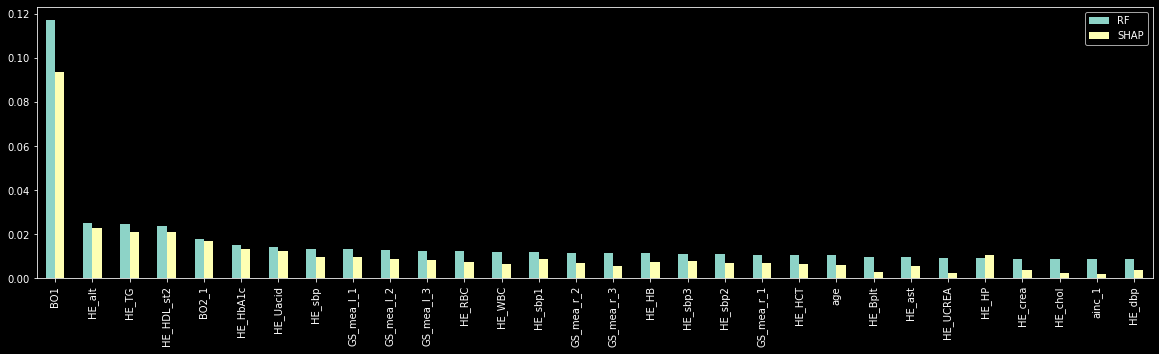

In [77]:
feat_imp = pd.concat([res, shap_feat_imp], axis=1)
feat_imp.columns = ['RF', 'SHAP']
fig, ax = plt.subplots(figsize=(20,5))
feat_imp.iloc[:30].plot.bar(ax=ax)

In [86]:
select_feat = feat_imp.index[1:8] # 8까지 하면 74% 10까지 해도 75% 30까지 해도 75%
X = data_2.loc[:,select_feat]
y = data_2.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train.shape, y_train.shape)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

(9252, 7) (9252,)
              precision    recall  f1-score   support

           0       0.70      0.69      0.69      1318
           1       0.77      0.78      0.77      1767

    accuracy                           0.74      3085
   macro avg       0.74      0.73      0.73      3085
weighted avg       0.74      0.74      0.74      3085



# PCA TEST

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# pipeline은 EDA 다 하고 나중에 모델만들고 해야함
from sklearn.pipeline import make_pipeline
# data_2.drop(['HE_BMI'], axis=1, inplace=True)
scaler = StandardScaler()
scaler = MinMaxScaler()
# pca = PCA(n_components=100)
pca = PCA()
pipeline = make_pipeline(scaler,pca)
pc = pipeline.fit(data_2.drop(['BMI_grade'], axis=1))

In [42]:
# ▶ pca.n_components_(차원 축소 주성분 개수)
features = range(pca.n_components_)
feature_df=pd.DataFrame(data=features,columns=['pc_feature'])

# ▶ pca.explained_variance_ratio_(설명력)
variance_df=pd.DataFrame(data=pca.explained_variance_ratio_,columns=['variance'])
pc_feature_df=pd.concat([feature_df,variance_df],axis=1)
pc_feature_df = pc_feature_df.set_index(['pc_feature'])
pc_feature_df.sum()

# ▶ StandardScaler -> 50 개 feature를 활용해도 67%밖에 설명할 수 없음
# ▶ MinMaxScaler -> 50 개 fealture를 활용하면 85%까지 설명 가능 but 8, 9에 대한 전처리 필요

variance    1.0
dtype: float64

# 수치형, 명목형 분리 -> 8, 9 제거하는 전처리 작업 해야함

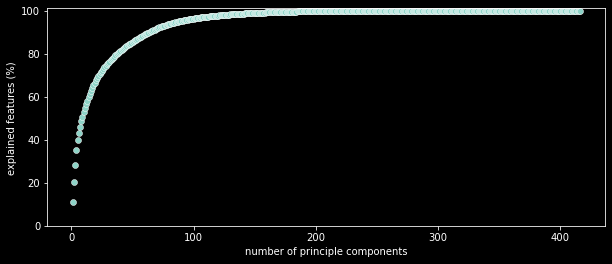

In [44]:
# ▶ 200개 PC까지 사용했을 때, 80%정도 분산을 설명할 수 있음
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['dark_background'])

fig, ax = plt.subplots(figsize = (10,4))
xi = np.arange(1, len(pc_feature_df)+1, step=1)
y = np.cumsum(pca.explained_variance_ratio_)*100

plt.ylim(0.0,101)
plt.xlabel('number of principle components')
plt.ylabel('explained features (%)')
sns.scatterplot(x=xi, y=y);

In [45]:
data_pca = pca.fit_transform(data_2)

In [52]:
# pca 단점, feature 이름을 알 수가 없음
data_pca.shape

(12337, 417)

아래 사이트 check해보기

https://jalynne-kim.medium.com/데이터-사이언스-주성분-분석-pca-principal-component-analysis-과-biplot-개념과-사례-레드와인-데이터-437283592031

___

In [48]:
# ▶ for문 활용 값 비교
# 유의미하게 차이나는 값은 8, 9 등의 영향일 수 있음
# 8, 9를 제거하는게 맞는것일까 하는 의문

for i, col in enumerate(data_2.drop(['BMI_grade'], axis=1).columns):
  print(f"{i}th feature name : {col}")
  print('↓')
  print(data_2.groupby('BMI_grade')[col].mean().sort_values(ascending=False))
  print('')
  print('-------------------------------------')

0th feature name : sex
↓
BMI_grade
0    1.637640
1    1.456836
Name: sex, dtype: float64

-------------------------------------
1th feature name : age
↓
BMI_grade
1    52.060147
0    47.558338
Name: age, dtype: float64

-------------------------------------
2th feature name : incm
↓
BMI_grade
0    2.559856
1    2.518539
Name: incm, dtype: float64

-------------------------------------
3th feature name : ho_incm
↓
BMI_grade
0    2.792639
1    2.702519
Name: ho_incm, dtype: float64

-------------------------------------
4th feature name : incm5
↓
BMI_grade
0    3.086132
1    3.021653
Name: incm5, dtype: float64

-------------------------------------
5th feature name : ho_incm5
↓
BMI_grade
0    3.298615
1    3.177045
Name: ho_incm5, dtype: float64

-------------------------------------
6th feature name : edu
↓
BMI_grade
0    3.094669
1    2.857487
Name: edu, dtype: float64

-------------------------------------
7th feature name : occp
↓
BMI_grade
1    4.535098
0    4.498387
Name: occp, dt

```
고도비만, 경도비만, 정상으로 나누고
UnderSampling을 해보면 좋을 것 같음
```